# 综述


_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_


我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 限定的误差范围（看各波段误差分布，取符合统计规律的限定）
* 去掉错误的点（见之前的程序)

操作：
* 蓝边缘选取（根据误差选择选取前%？的源，以及三sigema剔除）
* 对所有点算SFD,选取<0.05的源认为它没有消光
* 对蓝边缘点和SFD无消光点作拟合（拟合函数及方法暂定）

输出：
* 颜色-teff 图（其中包括全部数据点，蓝边缘点，SFD<0.05的点 ， parsec点，以及拟合曲线）



# 数据的引入和format (Alternative)

In [713]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
from scipy.optimize import curve_fit
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [771]:
#read as pandas
# starcatalog_fram = pd.read_csv(data_dir + 'LMOB-V4-SFDGP-right_panstar.csv') 
starcatalog_fram = pd.read_csv(data_dir + 'LMOB-V4-SFDGP-final-galex.csv')

###########
starcatalog_fram.columns
#print(starcatalog_fram)

Index(['col1', 'Unnamed: 0', 'TEFF', 'ERR_TEFF', 'RA', 'DEC', 'LOGG',
       'ERR_LOGG', 'FEH', 'ERR_FEH', 'SFD_ebv', 'l', 'b', 'J', 'ERR_J', 'H',
       'ERR_H', 'KS', 'ERR_KS', 'W1', 'ERR_W1', 'W2', 'ERR_W2', 'GMAG_gaia',
       'GBP', 'GRP', 'ra_x', 'dec_x', 'fuv_mag', 'nuv_mag', 'fuv_magerr',
       'nuv_magerr', 'objid', 'E_bv', 'objtype', 'fuv_flux', 'fuv_fluxerr',
       'nuv_flux', 'nuv_fluxerr', 'fuv_artifact', 'nuv_artifact', 'angDist'],
      dtype='object')

In [772]:
# fill the NaN blocks with 0

starcatalog_fram_fil0 = starcatalog_fram.fillna(0)

In [773]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'parsec-GALEX-SDSS.csv') #PARSEC2MASSandWISEMinus PARSECGALEXandSDSSPlus

############

print(parsec_fram.columns)

Index(['Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label',
       'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X',
       'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'FUVmag', 'NUVmag',
       'umag', 'gmag', 'rmag', 'imag', 'zmag'],
      dtype='object')


## 所需参数的选取（Input）

In [775]:
### variables

teff = 'TEFF'

color1 = 'fuv_mag'
color2 = 'nuv_mag'
err_teff = 'ERR_TEFF'

err_c1 =color1 + 'err'
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#'ERR_' + color1
#'e_' + color1

err_c2 =color2 + 'err'
#'ERR_' + color2
#'e_' + color2

## Logg选取(Input:)

In [776]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.0

Judge_logg = 3.5

starcatalog_fram_fil = starcatalog_fram_fil0[(starcatalog_fram_fil0['LOGG']> Judge_logg)]
parsec_fram = parsec_fram[(parsec_fram['logg']>Judge_logg)]                                            

## 测光误差的选取(input:)

In [777]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] > -99) \
                                          & (starcatalog_fram_fil[err_c2] > -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.2))
                                          & ((starcatalog_fram_fil[err_c2] <=0.2))]
#saturated magnitude

# if (color1=='J' or color2=='J'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['J'] >= 5.5)]
# if (color1=='H' or color2=='H'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['H'] >= 5)]  
# if (color1=='KS' or color2=='KS'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['KS'] >= 4.5)]
# if (color1=='W1' or color2=='W1'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W1'] >= 8.1)]
# if (color1=='W2' or color2=='W2'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W2'] >= 6.7)]  
# if (color1=='W3' or color2=='W3'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W3'] >= 3.8)

# if (color1=='gmag' or color2=='gmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['gmag'] >= 14)]
# if (color1=='rmag' or color2=='rmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['rmag'] >= 14)]
# if (color1=='imag' or color2=='imag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['imag'] >= 13)]
# if (color1=='zmag' or color2=='zmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['zmag'] >= 13)]
# if (color1=='ymag' or color2=='ymag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['ymag'] >= 13)]
        

if (color1=='gmag' or color2=='gmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['gmag'] >= 12)]
if (color1=='rmag' or color2=='rmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['rmag'] >= 12)]
if (color1=='imag' or color2=='imag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['imag'] >= 12)]
if (color1=='zmag' or color2=='zmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['zmag'] >= 12)]
if (color1=='ymag' or color2=='ymag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['ymag'] >= 12)]

## （金属丰度选取）(input:)

In [778]:
#FEH
# starcatalog_fram_fil=starcatalog_fram_fil[starcatalog_fram_fil['FEH'] > 0] # > <

## 有效温度及其误差选取(input:)

In [779]:
#USE goodOB 
teff_min=np.min(10000) #10000
teff_max=np.max(np.max(starcatalog_fram_fil['TEFF'])) #16000

starcatalog_fram_fil=starcatalog_fram_fil[(((starcatalog_fram_fil[err_teff] != 0 )\
                                          & (starcatalog_fram_fil[teff]>= teff_min)\
                                          & (starcatalog_fram_fil[teff]<= teff_max))\
                                          & (((starcatalog_fram_fil[err_teff]< 625)\
                                          &(starcatalog_fram_fil[teff]> 9000))\
                                          |((starcatalog_fram_fil[err_teff]< 500)\
                                          & (starcatalog_fram_fil[teff]<= 9000))))]
print('max_teff:',np.max(starcatalog_fram_fil[teff]))
print('the amount of available sources:',starcatalog_fram_fil.iloc[:,0].size)

max_teff: 22983.627
the amount of available sources: 992


## 蓝边缘的参数选取(input:)

In [780]:
# Ratio of the bluest edge, usually 5% 前%多少的源
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  #为保证统计的可靠性，每个区间最少的源为50
low_crit = 25

#the start teff 选取最低温度
teff_start= teff_min

#the pace of slide 滑动窗口的步长
slide_index = 200 



## parsec星表参数的选取(input:)

In [781]:
# parsec point  #16000:4.204 23000:4.362 选取温度范围
parsecframe = parsec_fram[((parsec_fram['logTe'] <= 4.37)\
                           &(parsec_fram['logTe'] >= 4))]

#the width of bin
bin_width_parsec = 200 #选取500一个bin

#确定开始和结束的温度
teff_start_parsec = teff_min
teff_end_parsec = teff_max

                                         

In [783]:
parseccolor1 = 'FUVmag'
parseccolor2 = 'NUVmag'
color_total = []
teff_total = []
#算色指数
for i in range(int((teff_end_parsec-teff_start_parsec)/bin_width_parsec)):
    parsecframe_bin = parsecframe[( (teff_start_parsec+i*bin_width_parsec) <=10**parsecframe['logTe']) & \
                (10**parsecframe['logTe']< (teff_start_parsec+ (i+1)*bin_width_parsec) )]
    color_total.append(np.median(np.array(parsecframe_bin[parseccolor1]-parsecframe_bin[parseccolor2])))#'Ksmag''NUVmag'
    teff_total.append(teff_start_parsec+(i+0.5)*bin_width_parsec)#选取bin中间温度为蓝边缘点的温度
    
parsec_color = np.array(color_total)
parsec_teff = np.array(teff_total)

# 内禀色指数的计算（蓝色边缘方法），同时取出某一部分用于SFD判断

## DEF

In [784]:
def data(teff_start,ratio,low_crit,ratio_SFD,slide_index):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];SFD_ebv = []
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 500:
        #print(teff_judge)
        if teff_judge <11000:
            bin_width = 300
        else:
            bin_width = 600

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+slide_index
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD['TEFF'].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])
            SFD_ebv.append(bin_tbl_SFD['SFD_ebv'].values[ppp])
        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        
        if len(color5) != 0:
            for i in range(20):
                bin_mean = np.median(color5)
                bin_sigma = np.std(color5)
                bin_int_color = color5\
                [((color5<= bin_mean+3*bin_sigma)\
                & (color5>= bin_mean-3*bin_sigma))]
                color5 = np.array(bin_int_color)
                print(bin_mean-3*bin_sigma)
                print(np.min(color5))

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+slide_index
        
    SFD_tbl_final = pd.DataFrame({'TEFF':np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2),'SFD_ebv':np.array(SFD_ebv)})
    
    #print(time.time() - start_time)
    print('int_Teff:',int_teff)
    print(' ') #让底下显示好看一些
    print('int_color:',int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

## 运算，SFD的准备（Input:)

In [785]:
# SFD ratio 需要计算SFD的比例，目前是全部计算

ratio_SFD = 100

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD,slide_index)



/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.364749889868
-0.155
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.179240318939
-0.056
-0.126178470312
-0.056
-0.126178470312
-0.056
-0.126178470312
-0.056
-0.12617847

# SFD的使用：—— 将使用到新的包

1. 选取SFD中Ebv小于某一个值的认为是零消光源（Lamost)——Thins page
2. 用目前的色指数减去 Ebv 给出的消光值，然后去归算内禀色指数 - GOSSS

In [786]:
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

#挑出SFD<0.05的源，把他们的色指数与有效温度储存备用
for i in range(lens):
    if SFD_tbl_ratio['SFD_ebv'].values[i] < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)

# print(time.time() - time_start)

10
47
50
74
78
82
83
92
107
108
126
137
161
168
169
177
178
181
233
243
251
255
256
290
309
315
320
323
369
370
406
409
411
465
467
504
511
513
531
624
634
635
655
716
745
755
758
776
858
904
1007
1017
1073
1128
1211
1354
1440
1569
1637
1798
1825
1915
1934
2015
2206
2235
2270


# 拟合（目前是指数函数）

In [787]:
# 指数函数
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 


## 蓝边缘函数拟合

In [788]:
int_teff_fit = list(np.array(int_teff)/10000)

popt, pcov = curve_fit(func, int_teff_fit, int_color,bounds=([0,0,-100000], [50,0.03 , -40]))

#popt数组中，三个值分别是待求参数a,b,c
colorvals = [func(i, popt[0],popt[1],popt[2]) for i in int_teff_fit]


print('function:',str(popt[0])+'* np.exp('+str(-popt[1])+'*x)'+str(popt[2])) #在屏幕上打印拟合多项式 
print(' ')
print('fit_teff:',int_teff_fit)
print(' ')
print('fit_color:',colorvals)
print(' ')
print('int_color:',int_color) #为了提取出来传到matlab里去拟合

function: 40.4874903692* np.exp(-0.0122791439555*x)-40.0000001103
 
fit_teff: [1.0149999999999999, 1.0349999999999999, 1.0549999999999999, 1.075, 1.095, 1.1299999999999999, 1.1499999999999999, 1.1699999999999999, 1.1899999999999999, 1.21, 1.23, 1.25, 1.27, 1.29, 1.3100000000000001, 1.3300000000000001, 1.3500000000000001, 1.3700000000000001, 1.3899999999999999, 1.4099999999999999, 1.4299999999999999, 1.45, 1.47, 1.49, 1.51]
 
fit_color: [-0.013987208313899657, -0.023805882787968358, -0.033622146259752128, -0.043435999321275176, -0.053247442564433811, -0.070411671394246866, -0.080216490687583075, -0.090018902380819554, -0.099818907065134965, -0.10961650533158718, -0.11941169777107774, -0.12920448497435899, -0.13899486753204826, -0.14878284603460656, -0.15856842107236702, -0.16835159323549931, -0.17813236311403102, -0.18791073129786184, -0.19768669837672803, -0.20746026494022374, -0.21723143157781521, -0.22700019887879108, -0.23676656743232627, -0.24653053782744649, -0.25629211065301405]


## SFD函数拟合

In [789]:
# 拟合SFD
SFD_catalog_teff_fit = list(np.array(SFD_catalog_teff)/10000)

popt_sfd, pcov_sfd = curve_fit(func, SFD_catalog_teff_fit, SFD_catalog_color,bounds=([0,0,-100000], [50,0.03 , -40]))
#popt数组中，三个值分别是待求参数a,b,c
SFD_vals = [func(i, popt_sfd[0],popt_sfd[1],popt_sfd[2]) for i in SFD_catalog_teff_fit]

print('fit_SFD_teff:',SFD_catalog_teff_fit)
print(' ')
print('fit_SFD_color:',SFD_vals)
print(' ')
print('SFD_color:',SFD_catalog_color) #同样是为了方便提取传入matlab
print(' ')
print('SFD_function:',str(popt_sfd[0])+'* np.exp('+str(-popt_sfd[1])+'*x)'+str(popt_sfd[2])) #在屏幕上打印拟合多项式

# fc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式
# SFD_vals=fitcurve(SFD_catalog_teff)


fit_SFD_teff: [1.0298555, 1.0120340000000001, 1.0294619, 1.0366438, 1.0388131999999999, 1.0298555, 1.0465103999999998, 1.0492444999999999, 1.0397563000000001, 1.0303530000000001, 1.0350714999999999, 1.0294619, 1.0503035000000001, 1.0549067999999999, 1.0465103999999998, 1.06545205, 1.0492444999999999, 1.0622153000000001, 1.0880315, 1.0777271000000002, 1.06545205, 1.0622153000000001, 1.0860916999999999, 1.0880315, 1.0958456999999999, 1.0902578999999999, 1.1078867999999999, 1.0860916999999999, 1.1245205, 1.1214720999999999, 1.1078867999999999, 1.1128584000000001, 1.1438608000000001, 1.1245205, 1.1214720999999999, 1.1640828999999999, 1.1774015, 1.1438608000000001, 1.1614176, 1.1640828999999999, 1.1774015, 1.1438608000000001, 1.1614176, 1.2030984, 1.1640828999999999, 1.2040187499999999, 1.1774015, 1.1614176, 1.2030984, 1.2040187499999999, 1.2460370999999999, 1.2030984, 1.2040187499999999, 1.2410950999999999, 1.2460370999999999, 1.2410950999999999, 1.2460370999999999, 1.2410950999999999, 1.3

# 图片输出

## 图片保存格式（Input:)

In [790]:
### figures & Savename
cc1 = 'FUV'
cc2 = 'NUV'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'LMOB'+'all'+'.png'
savename2 = save + date_now + cc1 + cc2 + 'LMOB'+'sfd'+'all'+'.png'
savename3 = save + date_now + cc1 + cc2 +'parsec_all.png'



## 绘图所需的具体量（Alternative)

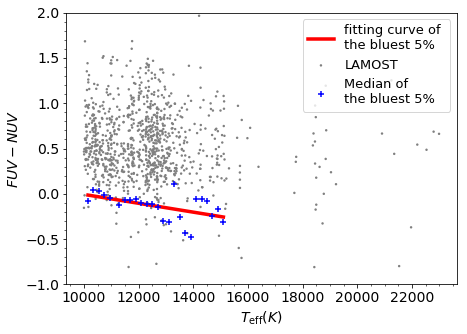

In [794]:
#PLT
ax = plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='grey',s=6, alpha = 1, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
#plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='black',s=7,label='SFD dustmap',zorder=2)

# SFD fitcurve
#plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.5,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.5,label='fitting curve of \nthe bluest 5%',zorder=1,alpha=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=45,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

#ic from parsec
#plt.scatter(parsec_teff,parsec_color,c='gold',s=5,label='PARSEC',zorder=2)
#plt.plot(parsec_teff, parsec_color, c='gold',linewidth = 3.5,label='PARSEC',zorder=1,alpha=2)
### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lightgreen',s=15,label='Allen')

plt.legend(loc='upper right',fontsize=13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.minorticks_on()
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
plt.ylim(-1,2)
#plt.yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6])
#plt.xlim(9000,25000)
plt.savefig(savename1,dpi=200)

plt.show()

#### 